In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   1.007518  0.690327  0.053286 -0.636444  0.011983 -1.171245  0.152272   
  1   0.536192  0.492196  0.532031  0.851618  0.356095 -0.544363  0.298892   
  2   1.401790 -0.083589 -0.408385 -0.232647  0.106472 -0.814438 -1.235738   
  3  -0.476577 -1.355902  0.416630  0.016192  0.546928  0.222398 -0.060528   
  4   0.634634 -0.066732  0.689374 -0.038623 -0.234535 -0.328660 -0.383060   
  5   0.149857 -0.061539  0.664667 -0.581922 -0.449910 -0.866840 -0.853624   
  6   0.317503 -0.503949  0.745293 -0.712920  0.140149  0.652521  0.199476   
  7   1.707650 -0.679281 -0.734143  0.032638 -0.828937  0.166452  0.445167   
  8  -0.066037 -0.367671  1.100482 -0.051501 -0.121934 -0.088068  0.643812   
  9   0.693597 -0.228427 -0.509158 -0.339016 -0.224998 -0.808369 -1.481549   
  10 -0.585184 -1.000557 -0.091364 -0.401168 -0.352756 -0.444918  0.385761   
  11  0.750858 -1.449136 -0.270956 -1.091789  0.345616 -0.900432 -0.775601   
  12 -0.145444 -0.905844  0.712434 -0.735246  0.520807 -1.249416 -0.178143   
  13 -0.294982 -0.451208 -0.051997  0.603338 -0.706011 -0.658854 -0.581226   
  14  0.552134 -0.022001  0.469122 -0.882190 -1.036488 -0.132681 -0.281678   
  15  0.339901 -0.381293  0.301164 -0.020234  0.146601 -0.378076  0.204167   
  16  0.233135 -0.559426  0.013360 -1.243732 -0.431300 -0.251257 -0.746457   
  17 -0.233127 -0.597632 -0.635406  0.343110  0.371824  0.276792  0.673412   
  18 -0.791846 -1.160291  0.577782  0.240448 -0.920347  0.948363  1.181571   
  19 -0.003752 -0.879750  0.867733 -0.027472  0.363713 -0.238209 -0.878315   
  20  1.118036 -0.106895 -0.180861 -1.241854 -0.793577 -0.325293  0.118460   
  21  1.084163 -0.306710 -0.693888 -1.300016 -0.951887  0.375694  0.157832   
  22  0.542122 -0.466381  0.132198  0.287237 -0.112051 -0.903243 -0.205217   
  23  0.300091 -0.169038  0.264198  0.957490  0.926028  0.970861  0.230567   
  24  1.420383 -0.241241  0.426645 -0.788225  0.360196  0.381048  0.215906   
1 0   0.292928  0.189403 -0.051368  0.080677  0.836752 -0.224060 -0.286440   
  1   0.184162  0.792062 -0.361067  0.399679 -0.290389  0.292053 -0.127343   
  2  -0.253355  0.102067 -0.368609  1.104354  1.021299 -0.653960 -0.338033   
  3  -0.991505  0.173473 -0.165579  1.126072 -0.040867  0.200753 -0.246710   
  4  -0.056116  0.034140  0.568020  1.332313  0.450195 -0.409660 -0.949069   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.492216 -0.306635 -0.658059  ... -0.472376 -0.218962 -0.811544   
  1  -0.386286 -0.991799 -0.534410  ...  0.599750 -0.968074 -0.741773   
  2  -0.047849  0.109311 -1.087869  ... -1.104641  0.482111  0.180992   
  3  -1.422439 -1.568979 -0.585103  ...  0.495984  0.064403  0.275002   
  4  -0.609123 -0.242956 -0.747758  ...  0.239748  0.733820 -0.498028   
  5  -0.891854 -0.293390  0.548849  ...  0.096066 -0.001474 -0.808444   
  6   0.329003  0.327283  0.695234  ... -0.069523  0.482193 -0.534585   
  7  -0.352602 -0.919253 -0.350461  ... -0.703702 -0.496860 -1.198847   
  8   0.230190  0.523111  0.772293  ...  0.653029  0.407866 -0.486084   
  9  -1.374458 -0.269732  0.212462  ...  0.263409  0.053563 -1.480076   
  10  0.226653 -0.168093 -0.153673  ...  0.850233  0.103795 -1.041864   
  11 -1.023677  0.245874  0.793160  ... -0.198864 -0.556550 -0.556917   
  12 -0.667362  0.210243  0.278821  ...  0.764998 -0.105146 -0.574185   
  13  0.644857  0.941259  0.486220  ... -0.728987 -0.728443 -0.406611   
  14 -0.270493  0.591833  0.812925  ... -0.512645 -0.534544 -0.659183   
  15 -0.202885 -0.331068 -0.430111  ... -0.033897  0.153748 -0.103267   
  16 -0.557380 -0.018490  0.050482  ... -0.341117  0.542583 -0.935353   
  17 -0.867162  0.624840  0.116682  ...  0.643699  0.553833 -0.443790   
  18 -0.498815 -0.638284 -0.141744  ... -0.930820 -0.638694 -0.937308   
  19 -1.149713 -0.292728 -1.190320  ...  0.147825  0.837056 -0.071946   
  20  0.169901 -0.164847  0.158533  ... -0.032366 -1.172588 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.070171  0.040766  26.251426  6.884708e-152  0.990271  1.150071


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



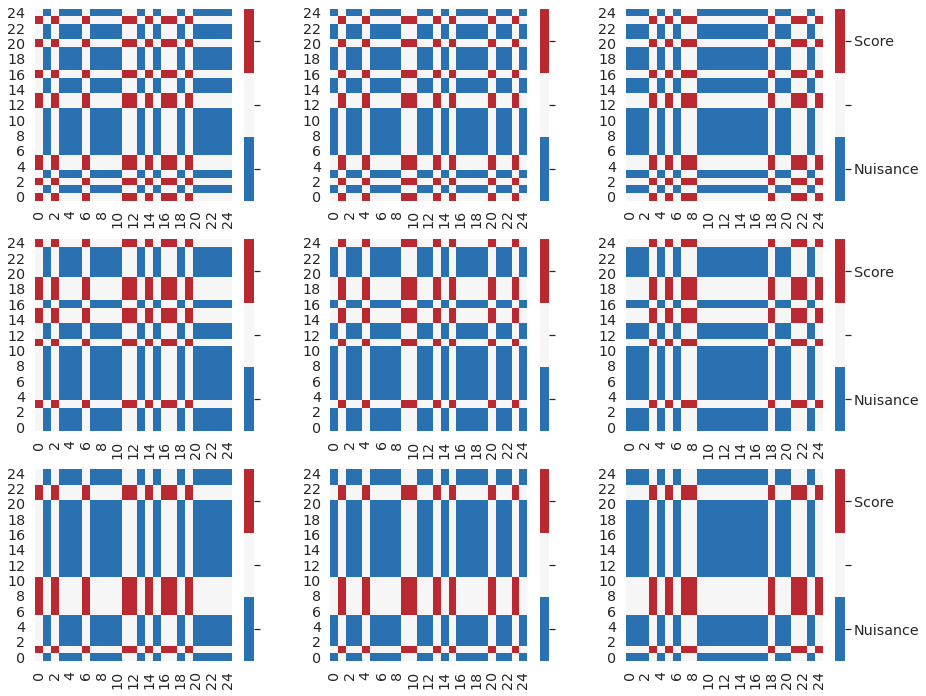

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



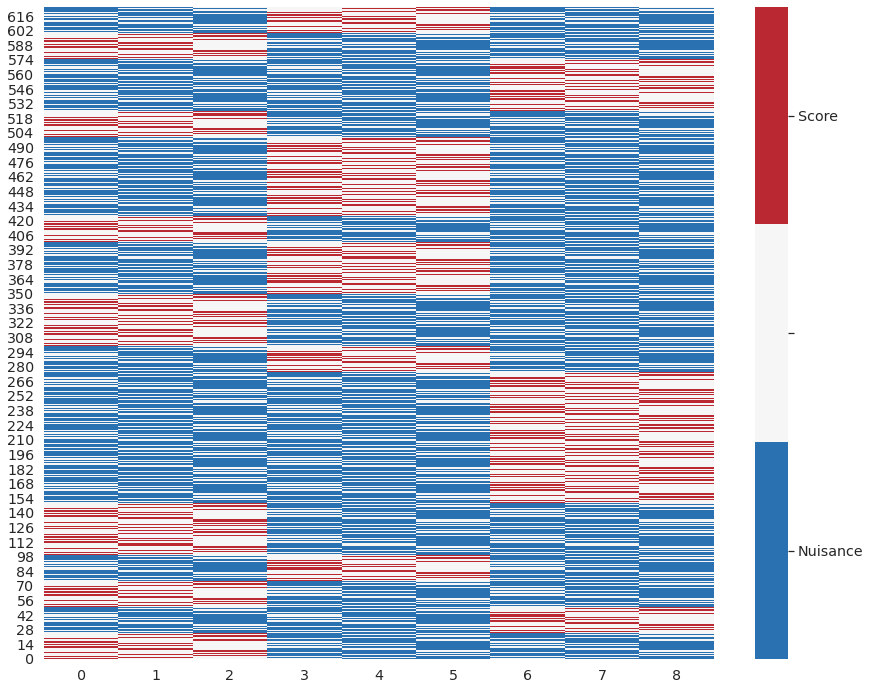

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])